# 01 — Baseline Random Forest (Student)

**Today we will:**
1) Load the Adult dataset (classification: `income`).
2) Split train/test **first** (avoid leakage).
3) Handle missing values (numeric: mean; categorical: most frequent).
4) Encode categorical features:
   - Label encode **one** column (`sex`)
   - One-hot encode the rest
5) (Practice) Scale numeric features (StandardScaler).
6) Train a **RandomForestClassifier** and evaluate it.
7) **Deep dive** into the RF object: attributes & methods.
8) Try a few hyperparameters and record results in your `students/experiment_log.md`.
9) Peek at **GridSearchCV** (teacher-led demo).

> As you work: add short notes in your experiment log (Goal → Setup → Results → Reflection).


### Setup

In [5]:
# 0) Setup
!pip -q install scikit-learn pandas matplotlib seaborn ucimlrepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml
from sklearn.utils import resample # downsample the dataset
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import ConfusionMatrixDisplay # creates and draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
print("Ready.")


Ready.


### Load data

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
# 1) Load the Adult dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame.copy()
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


**Question:** Is this a classification or regression problem?  
**Target column:** ???


### Choose columns & split FIRST

In [8]:
# 2) Choose columns (keep it small for speed)
numeric_features = ["age", "hours-per-week", "education-num", "capital-gain", "capital-loss"]
categorical_features = ["workclass", "marital-status", "occupation", "sex", "native-country"]
target_col = "class"

use_cols = numeric_features + categorical_features + [target_col]
df = df[use_cols].copy()



In [9]:
df_downsampled = resample(df, replace=False, n_samples=5000, random_state=42)

In [10]:
# 3) Split FIRST (to avoid leakage)
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((39073, 10), (9769, 10))

In [11]:
# reset indices
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# select ballers/nonballers
X_train_ballers = X_train_reset[y_train.reset_index(drop=True) == ">50K"]
y_train_ballers = y_train_reset[y_train.reset_index(drop=True) == ">50K"]

X_train_nonballers = X_train_reset[y_train.reset_index(drop=True) == "<=50K"] # select nonballers
y_train_nonballers = y_train_reset[y_train.reset_index(drop=True) == "<=50K"]

# concat X_train and y_train ballers and nonballers together
train_ballers = pd.concat([X_train_ballers, y_train_ballers], axis=1)
train_ballers_downsampled = resample(train_ballers, replace=False, n_samples=1000, random_state=42)

train_nonballers = pd.concat([X_train_nonballers, y_train_nonballers], axis=1)
train_nonballers_downsampled = resample(train_nonballers, replace=False, n_samples=1000, random_state=42)

# downsample ballers and nonballers
X_train_ballers_downsampled = train_ballers_downsampled.drop(columns=[target_col])
y_train_ballers_downsampled = train_ballers_downsampled[target_col]

X_train_nonballers_downsampled = train_nonballers_downsampled.drop(columns=[target_col])
y_train_nonballers_downsampled = train_nonballers_downsampled[target_col]


# Concatenate downsampled training data
X_train_downsampled = pd.concat([X_train_ballers_downsampled, X_train_nonballers_downsampled])
y_train_downsampled = pd.concat([y_train_ballers_downsampled, y_train_nonballers_downsampled])

# Display the shapes of the downsampled training data
print("Shape of downsampled X_train:", X_train_downsampled.shape)
print("Shape of downsampled y_train:", y_train_downsampled.shape)

display(X_train_downsampled.head())
display(y_train_downsampled.head())

Shape of downsampled X_train: (2000, 10)
Shape of downsampled y_train: (2000,)


,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
18623,46,60,13,15024,0,Private,Married-civ-spouse,Exec-managerial,Male,United-States
26702,40,45,9,0,1887,Private,Married-civ-spouse,Craft-repair,Male,United-States
34839,45,40,13,0,0,Local-gov,Married-civ-spouse,Exec-managerial,Male,United-States
8077,50,48,9,4386,0,Local-gov,Married-civ-spouse,Machine-op-inspct,Male,United-States
6202,32,40,14,14084,0,Private,Never-married,Exec-managerial,Male,United-States


,class
18623,>50K
26702,>50K
34839,>50K
8077,>50K
6202,>50K


In [12]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

X_test_ballers = X_test_reset[y_test_reset == ">50K"]
y_test_ballers = y_test_reset[y_test_reset == ">50K"]

X_test_nonballers = X_test_reset[y_test_reset == "<=50K"]
y_test_nonballers = y_test_reset[y_test_reset == "<=50K"]

test_ballers = pd.concat([X_test_ballers, y_test_ballers], axis=1)
test_ballers_downsampled = resample(test_ballers, replace=False, n_samples=1000, random_state=42)

test_nonballers = pd.concat([X_test_nonballers, y_test_nonballers], axis=1)
test_nonballers_downsampled = resample(test_nonballers, replace=False, n_samples=1000, random_state=42)


X_test_ballers_downsampled = test_ballers_downsampled.drop(columns=[target_col])
y_test_ballers_downsampled = test_ballers_downsampled[target_col]

X_test_nonballers_downsampled = test_nonballers_downsampled.drop(columns=[target_col])
y_test_nonballers_downsampled = test_nonballers_downsampled[target_col]


# Concatenate downsampled test data
X_test_downsampled = pd.concat([X_test_ballers_downsampled, X_test_nonballers_downsampled])
y_test_downsampled = pd.concat([y_test_ballers_downsampled, y_test_nonballers_downsampled])

# Display the shapes of the downsampled test data
print("\nShape of downsampled X_test:", X_test_downsampled.shape)
print("Shape of downsampled y_test:", y_test_downsampled.shape)

display(X_test_downsampled.head())
display(y_test_downsampled.head())


Shape of downsampled X_test: (2000, 10)
Shape of downsampled y_test: (2000,)


,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
2687,43,36,11,0,0,Private,Married-civ-spouse,Prof-specialty,Female,United-States
5936,34,40,10,0,0,Federal-gov,Married-AF-spouse,Adm-clerical,Female,United-States
1610,37,40,11,0,0,Private,Married-civ-spouse,Craft-repair,Male,United-States
9632,55,40,13,0,0,Private,Married-civ-spouse,Prof-specialty,Male,China
1081,56,32,15,0,0,Self-emp-inc,Married-civ-spouse,Prof-specialty,Male,United-States


,class
2687,>50K
5936,>50K
1610,>50K
9632,>50K
1081,>50K


In [13]:
display(X_train_ballers_downsampled.head())
display(y_train_ballers_downsampled.head())

display(X_train_nonballers_downsampled.head())
display(y_train_nonballers_downsampled.head())

,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
18623,46,60,13,15024,0,Private,Married-civ-spouse,Exec-managerial,Male,United-States
26702,40,45,9,0,1887,Private,Married-civ-spouse,Craft-repair,Male,United-States
34839,45,40,13,0,0,Local-gov,Married-civ-spouse,Exec-managerial,Male,United-States
8077,50,48,9,4386,0,Local-gov,Married-civ-spouse,Machine-op-inspct,Male,United-States
6202,32,40,14,14084,0,Private,Never-married,Exec-managerial,Male,United-States


,class
18623,>50K
26702,>50K
34839,>50K
8077,>50K
6202,>50K


,age,hours-per-week,education-num,capital-gain,capital-loss,workclass,marital-status,occupation,sex,native-country
24273,41,40,10,0,0,Private,Married-civ-spouse,Craft-repair,Male,Italy
10820,29,40,9,0,0,Private,Never-married,Machine-op-inspct,Female,United-States
13304,36,40,9,0,0,Private,Never-married,Prof-specialty,Male,United-States
9436,55,40,3,0,0,Private,Widowed,Machine-op-inspct,Female,United-States
25763,37,40,13,0,0,Private,Married-spouse-absent,Exec-managerial,Female,United-States


,class
24273,<=50K
10820,<=50K
13304,<=50K
9436,<=50K
25763,<=50K


**Why split first?**  
So that ....


In [14]:
X_train = X_train_downsampled
y_train = y_train_downsampled

X_test = X_test_downsampled
y_test = y_test_downsampled

### Handle missing values

In [15]:
# 4) Impute missing values
# Numeric → mean (try median later if you like)
num_imputer = SimpleImputer(strategy="mean")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_features]),
                           columns=numeric_features, index=X_train.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test[numeric_features]),
                           columns=numeric_features, index=X_test.index)

# Categorical → most frequent
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_raw = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_features]),
                               columns=categorical_features, index=X_train.index)
X_test_cat_raw  = pd.DataFrame(cat_imputer.transform(X_test[categorical_features]),
                               columns=categorical_features, index=X_test.index)


### Encode categoricals

In [16]:
# 5) Encode categoricals
# Label-encode ONE column ('sex'); one-hot the rest
label_encode_col = "sex"

# Copies
X_train_processed = X_train_cat_raw.copy()
X_test_processed  = X_test_cat_raw.copy()

# LabelEncoder: fit on train, apply to test
le = LabelEncoder()
X_train_processed[label_encode_col] = le.fit_transform(X_train_processed[label_encode_col])
X_test_processed[label_encode_col]  = le.transform(X_test_processed[label_encode_col])

# One-hot all other categorical columns
onehot_cols = [c for c in X_train_processed.columns if c != label_encode_col]

# Version-safe: sparse_output (>=1.2) vs sparse (<1.2)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_train_ohe_array = ohe.fit_transform(X_train_processed[onehot_cols])
X_test_ohe_array  = ohe.transform(X_test_processed[onehot_cols])

ohe_feature_names = ohe.get_feature_names_out(onehot_cols)
X_train_ohe = pd.DataFrame(X_train_ohe_array, columns=ohe_feature_names)
X_test_ohe  = pd.DataFrame(X_test_ohe_array,  columns=ohe_feature_names)

# Combine label-encoded + one-hot (reset indices for alignment)
label_encoded_train = X_train_processed[[label_encode_col]].reset_index(drop=True)
label_encoded_test  = X_test_processed[[label_encode_col]].reset_index(drop=True)
X_train_cat = pd.concat([label_encoded_train, X_train_ohe.reset_index(drop=True)], axis=1)
X_test_cat  = pd.concat([label_encoded_test,  X_test_ohe.reset_index(drop=True)],  axis=1)

X_train_cat.shape, X_test_cat.shape


((2000, 62), (2000, 62))

In [17]:
y_test

,class
2687,>50K
5936,>50K
1610,>50K
9632,>50K
1081,>50K
...,...
8336,<=50K
4369,<=50K
4048,<=50K
5419,<=50K


**Reflect:**  
- When might **label encoding** be risky?  
- Why is **one-hot** often safer for models like Logistic Regression or Neural Nets?


### Scale numeric features (practice)

In [18]:
# 6) Scale numeric features (practice—even if RF doesn’t need it)
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=numeric_features)
X_test_num_scaled  = pd.DataFrame(scaler.transform(X_test_num),   columns=numeric_features)

# Assemble final matrices (reset indices to align rows)
X_train_final = pd.concat([X_train_num_scaled.reset_index(drop=True),
                           X_train_cat.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([X_test_num_scaled.reset_index(drop=True),
                           X_test_cat.reset_index(drop=True)],  axis=1)

X_train_final.shape, X_test_final.shape


((2000, 67), (2000, 67))

**When would you prefer**:
- `MinMaxScaler` ?
- `RobustScaler` ?


# Random Forest

              precision    recall  f1-score   support

       <=50K       0.79      0.81      0.80      1000
        >50K       0.81      0.79      0.80      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



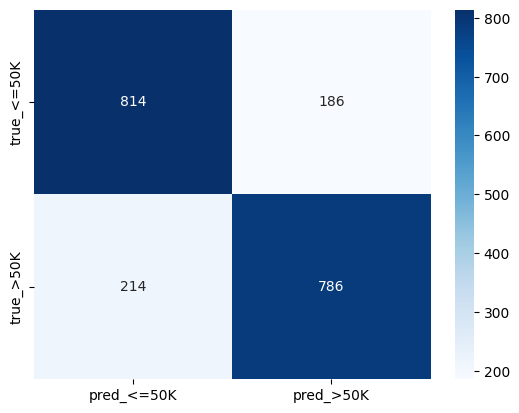

In [19]:
# 7) Train a baseline Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train)

y_pred = rf.predict(X_test_final)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
sns.heatmap(pd.DataFrame(cm, index=[f"true_{c}" for c in rf.classes_],
                            columns=[f"pred_{c}" for c in rf.classes_]),
            annot=True, fmt="d", cmap="Blues")
plt.show()


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

np.random.seed(seed=42)

# Define parameter distributions for RandomizedSearch
param_dist = {
    "n_estimators": randint(50, 300),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 10)
}

# GridSearch (small grid)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=3, scoring="accuracy", n_jobs=-1)

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                   param_dist, n_iter=10, cv=3,
                                   scoring="accuracy", n_jobs=-1,
                                   random_state=42)

print("Running GridSearchCV...")
grid.fit(X_train_final, y_train)

print("Running RandomizedSearchCV...")
random_search.fit(X_train_final, y_train)

print("Best params (GridSearch):", grid.best_params_)
print("Best score (GridSearch):", round(grid.best_score_, 4))

print("Best params (RandomizedSearch):", random_search.best_params_)
print("Best score (RandomizedSearch):", round(random_search.best_score_, 4))


Running GridSearchCV...
Running RandomizedSearchCV...
Best params (GridSearch): {'max_depth': 10, 'n_estimators': 200}
Best score (GridSearch): 0.8305
Best params (RandomizedSearch): {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 264}
Best score (RandomizedSearch): 0.8335


              precision    recall  f1-score   support

       <=50K       0.85      0.76      0.81      1000
        >50K       0.79      0.87      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.81      2000
weighted avg       0.82      0.82      0.81      2000



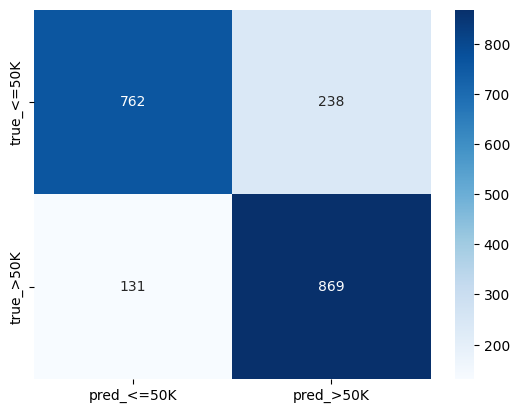

In [28]:
final_rf_classifier = RandomForestClassifier(n_estimators=264, max_depth=10, min_samples_split=4)
final_rf_classifier.fit(X_train_final, y_train)

y_pred = final_rf_classifier.predict(X_test_final)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=final_rf_classifier.classes_)
sns.heatmap(pd.DataFrame(cm, index=[f"true_{c}" for c in final_rf_classifier.classes_],
                            columns=[f"pred_{c}" for c in final_rf_classifier.classes_]),
            annot=True, fmt="d", cmap="Blues")
plt.show()

# Support Vector Machine

In [29]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_final, y_train)

SVC(random_state=42)

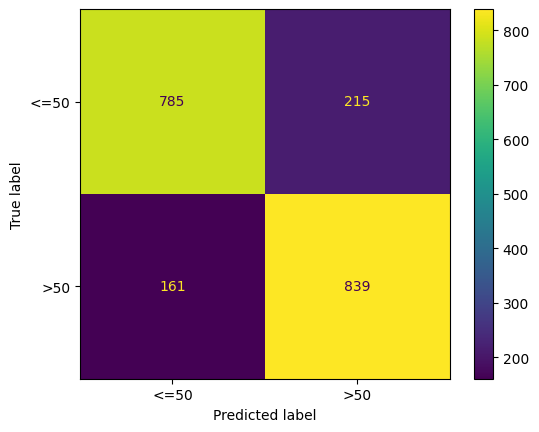

In [30]:
ConfusionMatrixDisplay.from_estimator(clf_svm,
                                      X_test_final,
                                      y_test,
                                      values_format='d',
                                      display_labels=["<=50", ">50"])

In [31]:
param_grid = [
  {
      'C': [0.1, 1, 10], # controls hard/soft margin
      'kernel': ['rbf', 'poly', 'sigmoid'], # chooses kernel
      'gamma': ['scale', 'auto', 0.1, 1], # influence of a single training point.
      'degree': [2, 3, 4], # used in poly kernel
      'coef0': [0.0, 0.1, 0.5], # used in poly and sigmoid
  },
]

optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1
    )

optimal_params.fit(X_train_final, y_train)
print(optimal_params.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'C': 1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [34]:
svm_final = SVC(random_state=42, C=1, gamma='scale')
svm_final.fit(X_train_final, y_train)

SVC(C=1, random_state=42)

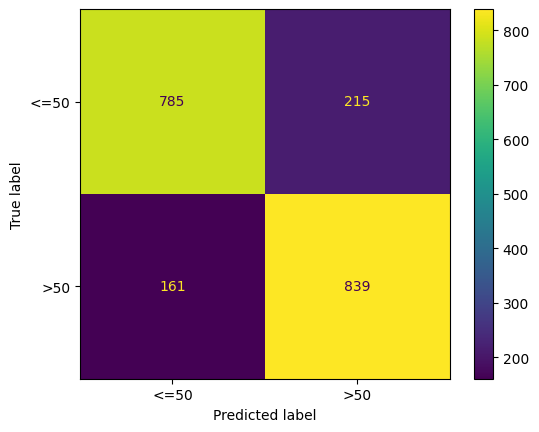

In [35]:
ConfusionMatrixDisplay.from_estimator(svm_final,
                                      X_test_final,
                                      y_test,
                                      values_format='d',
                                      display_labels=["<=50", ">50"])

### Saving Model Objects to a Pickle File

In [38]:
from google.colab import drive
drive.mount('/content/drive') # Mount your drive

Mounted at /content/drive


In [41]:
#change directory to where you want the model to be saved in your drive
%cd /content/drive/MyDrive/ADS2_Aaron/data

/content/drive/MyDrive/ADS2_Aaron/data


In [42]:
import pickle

filename = "01_baseline_svm_and_rf.pkl"

print("SAVING COMPLETE MODEL PACKAGE")
print("=" * 50)

# Create a complete model package
model_package = {
    'models': {"random_forest":final_rf_classifier, "svm":svm_final},
    'preprocessors': {
        'num_imputer': num_imputer,
        'scaler': scaler,
        'cat_imputer': cat_imputer,
        'label_encoder': le,
        'onehot_encoder': ohe
    },
    'data': {
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train,
        'y_test': y_test
    }
}


with open(filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"Saved: {filename}")

SAVING COMPLETE MODEL PACKAGE
Saved: 01_baseline_svm_and_rf.pkl
